In [16]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns


# Conference Predictor
## Custom Naive Bayes Functions

In [17]:
def p_x_given_class(obs_row, feature, class_,aggs):
    mu = aggs[feature]['mean'][class_]
    std = aggs[feature]['std'][class_]

    obs = obs_row[feature] #observation
    
    p_x_given_y = stats.norm.pdf(obs, loc=mu, scale=std)
    return p_x_given_y

def predict_class(obs_row,y_train,aggs,target_col=[0,1]):
    c_probs = []
    features_0 = {}
    features_1 = {}
    
    for i in range(len(target_col)):
        c = target_col[i]
        p = len(y_train[y_train==c])/len(y_train) #Initialize probability to relative probability of class
        for feature in X.columns:
            p *= p_x_given_class(obs_row, feature, c,aggs)
        c_probs.append(p)
    
    return target_col[np.argmax(c_probs)]

def predict_class2(obs_row,y_train,aggs,target_col=[0,1]):
    c_probs = []
    features_0 = {}
    features_1 = {}
    
    for i in range(len(target_col)):
        c = target_col[i]
        p = len(y_train[y_train==c])/len(y_train) #Initialize probability to relative probability of class
        for feature in X.columns:
            p *= p_x_given_class(obs_row, feature, c,aggs)
            if c == target_col[0]:
                features_0[feature]=p_x_given_class(obs_row, feature, c,aggs)
            elif c==target_col[1]:
                features_1[feature]=p_x_given_class(obs_row, feature, c,aggs)
        c_probs.append(p)
    
    return target_col[np.argmax(c_probs)] , features_0, features_1

def nba_stat_plot(bag,category,split_type):
    ind_cat=sorted(bag, key=bag.get,reverse =True)
    ind_val=sorted(bag.values(), reverse=True)
    stats = pd.DataFrame(list(zip(ind_cat,ind_val)),columns=['Stats','Count'])
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=stats['Stats'],y=stats['Count'],palette ="RdBu")
    sns.set_style("whitegrid", {'axes.grid' : False})
    ax.set_title(f'{category} Stat Indictors on {split_type} Data')

In [18]:
df = pd.read_csv('NBA_team_stats_2013to2019.csv',index_col=0)
print(len(df))
df.head()

209


,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,AST,STL,BLK,TOV,PF,PTS,Playoff,Location,Year,Conference
0,Nuggets,82,242.7,40.7,85.2,0.478,6.4,18.5,0.343,34.4,...,24.4,9.3,6.5,15.3,20.5,106.1,True,Denver,2013,Western
1,Rockets,82,241.2,38.1,82.7,0.461,10.6,28.9,0.366,27.5,...,23.2,8.3,4.4,16.4,20.3,106.0,True,Houston,2013,Western
2,Thunder,82,241.8,38.1,79.3,0.481,7.3,19.4,0.377,30.8,...,21.4,8.3,7.6,15.3,20.2,105.7,True,Oklahoma City,2013,Western
3,Spurs,82,242.4,39.1,81.4,0.481,8.1,21.5,0.376,31.1,...,25.1,8.5,5.4,14.7,17.4,103.0,True,San Antonio,2013,Western
4,Heat,82,242.4,38.4,77.4,0.496,8.7,22.1,0.396,29.6,...,23.0,8.7,5.4,13.9,18.7,102.9,True,Miami,2013,Eastern


In [19]:
X = df[[col for col in df.columns if col != 'Playoff' and col != 'Team' and 
        col != 'Location' and col != 'Conference' and col != 'G' and col != 'MP']]
y = df.Conference
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=8)

In [20]:
train = pd.concat([X_train, y_train], axis=1)
aggs = train.groupby('Conference').agg(['mean', 'std'])
aggs

FG                  FGA                 FG%            \
                 mean       std       mean       std      mean       std   
Conference                                                                 
Eastern     38.197468  1.827565  84.803797  2.982661  0.450532  0.013762   
Western     39.022078  1.861990  85.103896  2.904010  0.458545  0.014208   

                  3P                  3PA            ...       BLK            \
                mean       std       mean       std  ...      mean       std   
Conference                                           ...                       
Eastern     8.905063  1.973601  25.094937  5.213589  ...  4.756962  0.695163   
Western     9.085714  2.087287  25.322078  5.678436  ...  4.971429  0.790546   

                  TOV                   PF                   PTS            \
                 mean       std       mean       std        mean       std   
Conference                                                                   
Eastern     14.098734  1.150306  19.970886  1.467437  102.230380  5.466433   
Western     14.414286  1.067426  20.497403  1.483947  105.038961  5.335511   

                   Year            
                   mean       std  
Conference                         
Eastern     2015.987342  1.996752  
Western     2015.974026  1.999829  

[2 rows x 44 columns]

In [6]:
target_col = ['Eastern','Western']
y_hat_train =[]
y_hat_test=[]
feat0_train=[]
feat1_train=[]
feat0_test=[]
feat1_test=[]
bag1_train={}
bag2_train={}
bag3_train={}
bag1_test={}
bag2_test={}
bag3_test={}

for i,idx in enumerate(range(len(X_train))):
    a,b,c=predict_class2(X_train.iloc[idx],y_train,aggs,target_col)
    y_hat_train.append(a)
    feat0_train.append(b)
    feat1_train.append(c)
    
    difference = {key: abs((feat0_train[i][key] - feat1_train[i].get(key,0)))/((feat0_train[i][key]+feat1_train[i].get(key,0))/2) for key in feat0_train[i].keys()}
    x=sorted(difference, key=difference.get,reverse =True)
    y=sorted(difference.values(), reverse=True)
    bag1_train[x[0]]=bag1_train.get(x[0],0)+1
    bag2_train[x[1]]=bag2_train.get(x[1],0)+1
    bag3_train[x[2]]=bag3_train.get(x[2],0)+1

for i,idx in enumerate(range(len(X_test))):
    a,b,c=predict_class2(X_test.iloc[idx],y_train,aggs,target_col)
    y_hat_test.append(a)
    feat0_test.append(b)
    feat1_test.append(c)
    
    difference = {key: abs((feat0_test[i][key] - feat1_test[i].get(key,0)))/((feat0_test[i][key]+feat1_test[i].get(key,0))/2) for key in feat0_test[i].keys()}
    x=sorted(difference, key=difference.get,reverse =True)
    y=sorted(difference.values(), reverse=True)
    bag1_test[x[0]]=bag1_test.get(x[0],0)+1
    bag2_test[x[1]]=bag2_test.get(x[1],0)+1
    bag3_test[x[2]]=bag3_test.get(x[2],0)+1   

#m, y_hat_train = [predict_class(X_train.iloc[idx],target_col) for idx in range(len(X_train))]
# y_hat_test = [predict_class(X_test.iloc[idx],target_col) for idx in range(len(X_test))]

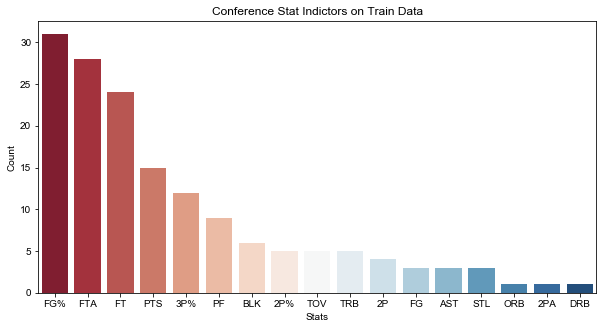

In [7]:
nba_stat_plot(bag1_train,'Conference',"Train")

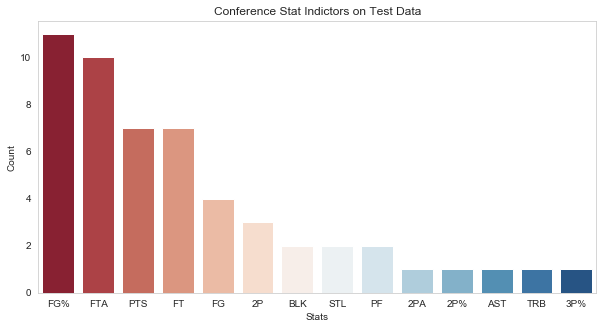

In [8]:
nba_stat_plot(bag1_test,'Conference','Test')

In [9]:
residuals_train = y_hat_train == y_train
acc_train = residuals_train.sum()/len(residuals_train)

residuals_test = y_hat_test == y_test
acc_test = residuals_test.sum()/len(residuals_test)

print(f'Correct Train Predict: {residuals_train.sum()}\t Wrong Train Predict: {len(residuals_train)-residuals_train.sum()}')
print(f'Correct Test Predict: {residuals_test.sum()}\t Wrong Test Predict: {len(residuals_test)-residuals_test.sum()}')
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(acc_train, acc_test))

Correct Train Predict: 106	 Wrong Train Predict: 50
Correct Test Predict: 34	 Wrong Test Predict: 19
Training Accuracy: 0.6794871794871795	Testing Accuracy: 0.6415094339622641


## Gaussian Naive Bayes with Sklearn

In [15]:
model = GaussianNB()

model.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [11]:
y_train_predict=model.predict(X_train)
y_test_predict2=model.predict(X_test)

In [23]:
print("Sklearn Train Accuracy:",metrics.accuracy_score(y_train, y_train_predict))
print("Sklearn Test Accuracy:",metrics.accuracy_score(y_test, y_test_predict2))

Sklearn Train Accuracy: 0.6794871794871795
Sklearn Test Accuracy: 0.6415094339622641


In [30]:
print('Sklearn Train ROC score: ',metrics.roc_auc_score(y_train == "Western", y_train_predict == "Western"))
print('Sklearn Test ROC score: ',metrics.roc_auc_score(y_test=='Western', y_test_predict2=='Western'))

Sklearn Train ROC score:  0.6784481341443367
Sklearn Test ROC score:  0.6417378917378918
